In [5]:
%run FUNCIONES_GENERALES.ipynb

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [39]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# skforecast
import skforecast
import pandas as pd
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import auto_arima 

import warnings
warnings.filterwarnings('once')

Ejemplos general:

In [1]:
fecha1='1/1/2012'

In [2]:
fecha2='1/1/2024'

In [3]:
fecha3='1/1/2026'

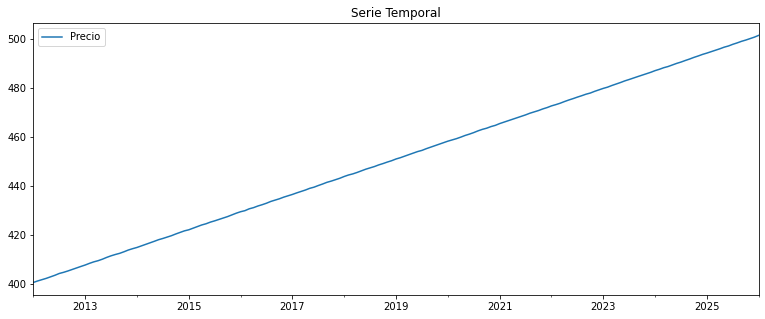

In [17]:
datos = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[400,0.6],1,0.2)

In [20]:
display(datos.head())

,Precio
2012-01-01,400.730725
2012-02-01,401.334968
2012-03-01,401.848744
2012-04-01,402.401003
2012-05-01,403.023553


In [43]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2024-01-01 23:59:59'
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

BACKTESTING:

In [ ]:
def prediccion_autorregresivos(datos,datos_train,fin_train):
    
    # Grid search
    forecaster = ForecasterSarimax(
                    regressor=Sarimax(
                                    order=(1, 1, 1), # Placeholder replaced in the grid search
                                    maxiter=500
                                )
                )

    param_grid = {
        'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
        'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
        'trend': [None]
    }

    resultados_grid = grid_search_sarimax(
                            forecaster            = forecaster,
                            y                     = datos_train['Precio'],
                            param_grid            = param_grid,
                            steps                 = 12,
                            refit                 = True,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            return_best           = False,
                            n_jobs                = 'auto',
                            suppress_warnings_fit = True,
                            verbose               = False,
                            show_progress         = True
                    )
    r=resultados_grid.index[0]
    
    # Auto arima: seleccion basada en AIC
    # ==============================================================================
    modelo = auto_arima(
                y                 = datos_train['Precio'],
                start_p           = 0,
                start_q           = 0,
                max_p             = 3,
                max_q             = 3,
                seasonal          = True,
                test              = 'adf',
                m                 = 12, # periodicidad de la estacionalidad
                d                 = None, # El algoritmo determina 'd'
                D                 = None, # El algoritmo determina 'D'
                trace             = True,
                error_action      = 'ignore',
                suppress_warnings = True,
                stepwise          = True
            )
    # Predicciones de backtesting con el mejor modelo según el grid search
    # ==============================================================================
    forecaster_1 = ForecasterSarimax( regressor=Sarimax(order=resultados_grid.order[r], seasonal_order=resultados_grid.seasonal_order[r], maxiter=500),
                    )

    metrica_m1, predicciones_m1 = backtesting_sarimax(
                                            forecaster            = forecaster_1,
                                            y                     = datos['Precio'],
                                            initial_train_size    = len(datos.loc[:fin_val]),
                                            steps                 = 24,
                                            metric                = 'mean_absolute_error',
                                            refit                 = True,
                                            n_jobs                = "auto",
                                            suppress_warnings_fit = True,
                                            verbose               = False,
                                            show_progress         = True
                                        )

    # Predicciones de backtesting con el mejor modelo según auto arima
    # ==============================================================================
    forecaster_2 = ForecasterSarimax(
                        regressor=Sarimax(order=modelo.order, seasonal_order=modelo.seasonal_order, maxiter=500),
                    )

    metrica_m2, predicciones_m2 = backtesting_sarimax(
                                            forecaster            = forecaster_2,
                                            y                     = datos['Precio'],
                                            initial_train_size    = len(datos.loc[:fin_val]),
                                            steps                 = 24,
                                            metric                = 'mean_absolute_error',
                                            refit                 = True,
                                            n_jobs                = "auto",
                                            suppress_warnings_fit = True,
                                            verbose               = False,
                                            show_progress         = True
                                        )
    
    # Comparación de métricas
    # ==============================================================================
    print("Metrica (mean absolute error) del modelo grid search:")
    display(metrica_m1)
    print("Metric (mean_absolute_error) del modelo auto arima:")
    display(metrica_m2)

    fig, ax = plt.subplots(figsize=(6, 3))
    datos.loc[fin_val:].plot(ax=ax, label='test')
    predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
    predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
    predicciones_m1.plot(ax=ax)
    predicciones_m2.plot(ax=ax)
    ax.set_title('Predicciones de backtesting con un modelo SARIMA')
    ax.legend()
    
    return min(metrica_m1,metrica_m2)

In [53]:
# Grid search
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
            )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None]
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos_train['Precio'],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )




Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

In [97]:
r=resultados_grid.index[0]

In [59]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos_train['Precio'],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1350.466, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2181.678, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=139.043, Time=0.14 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-218.493, Time=0.43 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-226.779, Time=1.57 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-215.824, Time=2.00 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-226.898, Time=0.53 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.

In [117]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax( regressor=Sarimax(order=resultados_grid.order[r], seasonal_order=resultados_grid.seasonal_order[r], maxiter=500),
                )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                        forecaster            = forecaster,
                                        y                     = datos['Precio'],
                                        initial_train_size    = len(datos.loc[:fin_val]),
                                        steps                 = 24,
                                        metric                = 'mean_absolute_error',
                                        refit                 = True,
                                        n_jobs                = "auto",
                                        suppress_warnings_fit = True,
                                        verbose               = False,
                                        show_progress         = True
                                    )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                    regressor=Sarimax(order=modelo.order, seasonal_order=modelo.seasonal_order, maxiter=500),
                )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                        forecaster            = forecaster,
                                        y                     = datos['Precio'],
                                        initial_train_size    = len(datos.loc[:fin_val]),
                                        steps                 = 24,
                                        metric                = 'mean_absolute_error',
                                        refit                 = True,
                                        n_jobs                = "auto",
                                        suppress_warnings_fit = True,
                                        verbose               = False,
                                        show_progress         = True
                                    )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,0.04875


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,0.059441


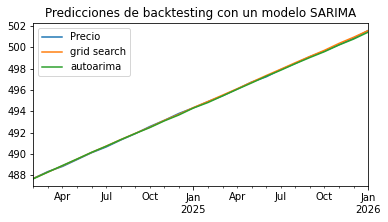

In [119]:
# Comparación de métricas
# ==============================================================================
print("Metrica (mean absolute error) del modelo grid search:")
display(metrica_m1)
print("Metric (mean_absolute_error) del modelo auto arima:")
display(metrica_m2)

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()